In [2]:
import pandas as pd
import numpy as np
from scipy.optimize import curve_fit
from matplotlib import pyplot as plt

In [3]:
# classes to perform the fitting to the linear and non-linear model

class BDE():
    def __init__(self, energies, nuc_charges, unit = 'kcal'):
        if unit == 'kcal':
            ha2kcal = 630
        elif unit == 'atomic':
            ha2kcal = 1
        # define energies
        self.bde = -energies[:,0]*ha2kcal
        self.bfe = energies[:,0]*ha2kcal
        self.ebfe = energies[:,1]*ha2kcal
        self.nbfe = energies[:,2]*ha2kcal
        
        # define charge combinations Z1, Z2
        self.nuc_charges = nuc_charges
#         if row == 2:
#             self.nuc_charges = [6, 7, 8, 9]
#         elif row == 3:
#             self.nuc_charges = [14, 15, 16, 17]
#         elif row == 4:
#             self.nuc_charges = [32, 33, 34, 35]
        self.init_xdata(self.nuc_charges)
        
    def fit(self, model, p0 = None):
        if p0 is not None:
            self.params = curve_fit(model, self.xdata, self.ebfe, p0, maxfev=100000)
        else:
            self.params = curve_fit(model, self.xdata, self.ebfe)
        
        self.ebfe_fitted = model(self.xdata, *self.params[0])
        self.bde_fitted = -(self.ebfe_fitted + self.nbfe)
        self.mae = np.abs(self.bde_fitted-self.bde).mean()
    
    def init_xdata(self, nuc_charges):
        self.xdata = []
        for i in range(len(nuc_charges)):
            for j in range(i, len(nuc_charges)):
                self.xdata.append([nuc_charges[i], nuc_charges[j]])
        self.xdata = np.array(self.xdata)
    
    def get_coeff_mat(self):
        num_eq = len(self.ebfe)
        num_coeffs = 2*len(self.nuc_charges)
        self.coeff_mat = np.zeros((num_eq, num_coeffs))
        
        ind_a = []
        for i in range(len(self.nuc_charges)):
            for j in range(i, len(self.nuc_charges)):
                ind_a.append([i, j])
        
        for i, z, a in zip(range(num_eq), self.xdata, ind_a):
            # set a
            self.coeff_mat[i][a[0]] += 1
            self.coeff_mat[i][a[1]] += 1
            # set b, the index can be calculated from the indices for a
            b = [a[0]+len(self.nuc_charges), a[1]+len(self.nuc_charges)]
            self.coeff_mat[i][b[0]] += z[1]
            self.coeff_mat[i][b[1]] += z[0]
        return(self.coeff_mat)

    def linear_fit(self):
        self.linear_params, mae_waste, self.linear_rank, self.linear_sg = np.linalg.lstsq(self.get_coeff_mat(), self.ebfe, rcond=None)
        self.ebfe_fitted = self.linear_params@self.coeff_mat.T
        self.bfe_fitted = self.ebfe_fitted + self.nbfe
        self.bde_fitted = -self.bfe_fitted
        self.linear_mae = np.abs(self.bde_fitted - self.bde).mean()
        
    def train(self, tr_ind, model, p0 = None):
        if p0 is not None:
            self.params_tr = curve_fit(model, self.xdata[tr_ind], self.ebfe[tr_ind], p0, maxfev=100000)
        else:
            self.params_tr = curve_fit(model, self.xdata[tr_ind], self.ebfe[tr_ind])

        self.ebfe_fitted_tr = model(self.xdata[tr_ind], *self.params_tr[0])
        self.bde_fitted_tr = -(self.ebfe_fitted_tr + self.nbfe[tr_ind])
        self.mae_tr = np.abs(self.bde_fitted_tr-self.bde[tr_ind]).mean()

    def predict(self, test_ind, model):
        self.ebfe_fitted_test = model(self.xdata[test_ind], *self.params_tr[0])
        self.bde_fitted_test = -(self.ebfe_fitted_test + self.nbfe[test_ind])
        self.mae_test = np.abs(self.bde_fitted_test-self.bde[test_ind]).mean()

        
class BDE_clean(BDE):
    def __init__(self,bfe, bde, ebfe, nbfe, Z1, Z2, xdata):
        self.bfe = bfe
        self.bde = bde
        self.ebfe = ebfe
        self.nbfe = nbfe
        self.Z1 = Z1
        self.Z2 = Z2
        self.xdata = xdata
        
    @classmethod
    def fromdict(cls, datadict):
        # get units
        if 'unit' in datadict.keys():
            e_unit = datadict['unit']
        else:
            e_unit = 1 # use Hartree as energy unit
            
        # bond energy
#         if datadict['bfe type'] == 'isodesmic':
#             bfe = np.array(datadict['bfe isodesmic'])*e_unit
#         else:
        bfe = np.array(datadict['bfe'])*e_unit # homolytic set to default
        bde = -bfe
        
        # nuclear charges
        Z1 = np.array(datadict['Z1'])
        Z2 = np.array(datadict['Z2'])
        
        # nuclear repulsion
        if 'nbfe' in datadict.keys():
            nbfe = np.array(datadict['nbfe'])*e_unit
        else:
            nbfe = Z1*Z2*e_unit
            
        # electronic bond energy
        ebfe = bfe - nbfe
        
        # xdata
        xdata = np.array([Z1, Z2]).T
        return(cls(bfe, bde, ebfe, nbfe, Z1, Z2, xdata))
    
    def get_coeff_mat(self):
        """
        matrix with coefficients for linear fit
        """
        
        unique_Z = np.sort(np.unique(np.concatenate((self.Z1, self.Z2))))
        index_a = dict(zip(unique_Z, np.arange(len(unique_Z))))
        index_b = dict(zip(unique_Z, np.arange(len(unique_Z), 2*len(unique_Z))))
        coeff_mat = np.zeros((len(self.Z1), 2*len(unique_Z))) # there are two parameters for every element
        
        for row, Z1, Z2 in zip(range(len(self.Z1)), self.Z1, self.Z2):
            # coefficients for Z1
            coeff_mat[row, index_a[Z1]] += 1
            coeff_mat[row, index_b[Z1]] += Z2
            # coefficients for Z2
            coeff_mat[row, index_a[Z2]] += 1
            coeff_mat[row, index_b[Z2]] += Z1
            
        self.coeff_mat = coeff_mat
        return(self.coeff_mat)

### load data

In [4]:
data = pd.read_csv('/data/sahre/projects/atomic-energies/data/bonding_trends/pbe0_data/energies_homolytic.csv')
data_2 = data.loc[(data['Z1'] >= 6) & (data['Z1'] <= 9) & (data['Z2'] >= 6) & (data['Z2'] <= 9)].to_dict('list')
data_3 = data.loc[(data['Z1'] >= 14) & (data['Z2'] >= 14) & (data['Z1'] <= 17) & (data['Z2'] <= 17)].to_dict('list')
data_4 = data.loc[(data['Z1'] >= 32) & (data['Z2'] >= 32) & (data['Z1'] <= 35) & (data['Z2'] <= 35)].to_dict('list')

for d in [data_2, data_3, data_4]:
    d['unit'] = 630
    d['bfe type'] = 'homo'

### linear model

In [5]:
b2 = BDE_clean.fromdict(data_2)
b3 = BDE_clean.fromdict(data_3)
b4 = BDE_clean.fromdict(data_4)
for b in [b2, b3, b4]:
    b.linear_fit()
    rounded_MAE = np.round((np.abs(b.bde-b.bde_fitted)).mean(),2)
    rounded_MAE_std = np.round(rounded_MAE/b.bde.std(), 2)
    print(f'MAE = {rounded_MAE} ({rounded_MAE_std})')

MAE = 0.51 (0.02)
MAE = 0.39 (0.03)
MAE = 0.33 (0.03)


### $\gamma$-exponent non-linear model

#### individually optimized $\gamma$ for each row

In [6]:
def non_linear_model(var, a, b, c):
    Z1, Z2 = var.T
#     gamma = 7/3
    ebfe = -a**2 - b**2*Z1*Z2 - c**2*(Z1**(gamma)+Z2**(gamma))
    return(ebfe)

b2_nl = BDE_clean.fromdict(data_2)
b3_nl = BDE_clean.fromdict(data_3)
b4_nl = BDE_clean.fromdict(data_4)


p2 = [15, 24,  1.9]
p3 = [19.81710356, 24.92342986,  1.22294599]
p4 = [33.3052603 , 24.97639216,  0.90171214]

maes = []
for gamma in np.linspace(0.5, 4, 50):
    mae_row = []
    for b, p0 in zip([b2_nl, b3_nl, b4_nl], [p2, p3, p4]):

        b.fit(non_linear_model, p0=p0)
        #print('MAE = ' + str((np.abs(b.bde-b.bde_fitted)).mean()))
        rounded_MAE = np.round((np.abs(b.bde-b.bde_fitted)).mean(),2)
        rounded_MAE_std = np.round(rounded_MAE/b.bde.std(), 2)
#         print(rounded_MAE)
#         print(b.params[0])
        mae_row.append((np.abs(b.bde-b.bde_fitted)).mean())
    maes.append(mae_row)

/home/sahre/opt/miniconda3/envs/qm-tools/lib/python3.9/site-packages/scipy/optimize/_minpack_py.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


#### one $\gamma$-exponent for all rows

In [7]:
def non_linear_model(var, a, b, c):
    Z1, Z2 = var.T
#     gamma = 7/3
    ebfe = -a**2 - b**2*Z1*Z2 - c**2*(Z1**(gamma)+Z2**(gamma))
    return(ebfe)
gammas = []
MAEs= []
# do non linear fits
b2_nl = BDE_clean.fromdict(data_2)
b3_nl = BDE_clean.fromdict(data_3)
b4_nl = BDE_clean.fromdict(data_4)
for gamma in np.linspace(0.5, 4, 50):
    overall_mae = []
    
    p2 = [14.68820305, 24.89036038,  1.40953664]
    p3 = [19.81710356, 24.92342986,  1.22294599]
    p4 = [33.3052603 , 24.97639216,  0.90171214]
    
    for b, p0 in zip([b2_nl, b3_nl, b4_nl], [p2, p3, p4]):

        b.fit(non_linear_model, p0=p0)
        #print('MAE = ' + str((np.abs(b.bde-b.bde_fitted)).mean()))
        rounded_MAE = np.round((np.abs(b.bde-b.bde_fitted)).mean(),2)
        rounded_MAE_std = np.round(rounded_MAE/b.bde.std(), 2)
#         print(f'MAE = {rounded_MAE} ({rounded_MAE_std})')
        overall_mae.append((np.abs(b.bde-b.bde_fitted)).mean())
    MAE = (np.array(overall_mae)).mean()
    #print(f'gamma = {gamma}, MAE = {MAE}')
    
    gammas.append(gamma)
    MAEs.append(MAE)

Text(0, 0.5, 'MAE (kcal/mol)')

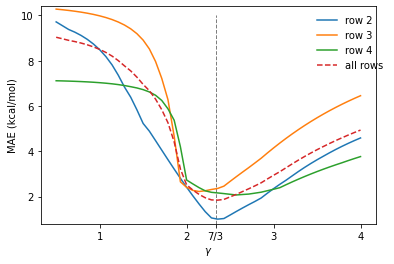

In [8]:
gamma_val = np.linspace(0.5, 4, 50)
fig, ax = plt.subplots(1,1)
ax.plot(gamma_val, np.array(maes)[:,0], label = 'row 2')
ax.plot(gamma_val, np.array(maes)[:,1], label = 'row 3')
ax.plot(gamma_val, np.array(maes)[:,2], label = 'row 4')

ax.plot(gammas, MAEs, '--', label = 'all rows')

ax.vlines(7/3, 0.8, 10, linestyles = '--', linewidth = 1, color= 'tab:gray')
ax.legend(frameon= False, bbox_to_anchor = (1.05,1))
ax.set_ylim([0.8, 10.4])
ax.set_xticks([1,2,7/3,3,4])
ax.set_xticklabels(['1','2','7/3','3','4'])
ax.set_xlabel(r'$\gamma$')
ax.set_ylabel('MAE (kcal/mol)')

### non-linear model

In [9]:
def non_linear_model(var, a, b, c):
    Z1, Z2 = var.T
    gamma = 7/3
    ebfe = -a**2 - b**2*Z1*Z2 - c**2*(Z1**(gamma)+Z2**(gamma))
    return(ebfe)

# do linear fits
b2_nl = BDE_clean.fromdict(data_2)
b3_nl = BDE_clean.fromdict(data_3)
b4_nl = BDE_clean.fromdict(data_4)

for b in [b2_nl, b3_nl, b4_nl]:
    b.fit(non_linear_model, p0 = [33.3052603 , 24.97639216,  0.90171214])
    #print('MAE = ' + str((np.abs(b.bde-b.bde_fitted)).mean()))
    rounded_MAE = np.round((np.abs(b.bde-b.bde_fitted)).mean(),2)
    rounded_MAE_std = np.round(rounded_MAE/b.bde.std(), 2)
    print(f'MAE = {rounded_MAE} ({rounded_MAE_std})')

MAE = 1.0 (0.04)
MAE = 2.35 (0.17)
MAE = 2.17 (0.21)
